In [21]:
"""
The MPO-MPS method for SO(4) BBQ model with good quantum number U(1)xU(1) given by Cartan subalgebra. 

Puiyuen 2024.10.24
    2024.10.24: code collection, ONLY support U(1)xU(1) symmetry
"""
import matplotlib.pyplot as plt
from tenpy.tools.params import asConfig
from tenpy.models.model import CouplingModel, MPOModel
from tenpy.networks.site import Site, SpinSite, SpinHalfFermionSite, FermionSite
from tenpy.models.lattice import Chain, Square
from tenpy.networks.mps import MPS
import tenpy.linalg.np_conserved as npc
import argparse
import pickle
import itertools
import matplotlib.pyplot as plt
import numpy as np
from bdgpack import *
from so4bbqham import *
from tenpy.algorithms import dmrg
import logging
logging.getLogger('parso.python.diff').disabled = True
logging.getLogger('parso.cache').disabled = True
logging.getLogger('matplotlib.font_manager').disabled = True

class SpinDoubleChain():
    def __init__(self, chi, delta, lamb, L, pbc):
        """
        The Double Spin chain class, defined under the standard basis. 
        
        The Hamiltonian is in the BdG form, the matrix is written under the Bogoliubov *QUASIHOLE* representation. 
        """
        self.L = L
        self.chi = chi
        self.delta = delta
        self.lamb = lamb
        self.pbc = pbc
        self.model = "double Kitaev chain parameters_L{}_chi{}_delta{}_lambda{}_pbc{}".format(L, round(chi, 3), round(delta, 3), round(lamb, 3), pbc)
        self.dtype = np.float64
        if pbc not in [1, 0, -1]:
            raise "Check pbc must be 0:open or 1:periodic or -1:anti-periodic"
        
    def Wannier_Z2(self, g1, g2, N=1):
        norbital, n = g1.shape        
        position = np.power( list(range(1,n+1)), N)
        position = np.diag(position) 
        position12 = g1.conj() @ position @ g1.T + g2.conj() @ position @ g2.T
        position12 = (position12 + position12.T.conj())/2.
        D, U = np.linalg.eigh(position12)
        index = np.argsort(D)
        print('The MLWOs locate at', D)
        U = U[:,index]
        g3 = U.T @ g1
        g4 = U.T @ g2
        index1 = np.zeros(norbital, dtype=int)
        if norbital%2 == 0:
            index1[0:(norbital):2] = np.ceil( range(0, norbital//2) ).astype(int)
            index1[1:(norbital):2] = np.ceil( range(norbital-1, norbital//2-1, -1) ).astype(int)
        else:
            index1[0:(norbital):2] = np.ceil( range(0, norbital//2+1) ).astype(int)
            index1[1:(norbital):2] = np.ceil( range(norbital-1, norbital//2, -1) ).astype(int)
        g3 = g3[index1,:]
        g4 = g4[index1,:]
        return g3.T, g4.T
            
    def calc_hamiltonian(self):
        L = self.L
        t = -self.chi
        d = self.delta
        mu = self.lamb
        self.tmat = np.zeros((L,L), dtype=float)
        self.dmat = np.zeros((L,L), dtype=float)
        for i in range(L):
            self.tmat[i, i] = mu/2 
        for i in range(L-1):
            self.tmat[i, (i+1)%L] = t 
            self.dmat[i, (i+1)%L] = d 

        if self.pbc == 1:
            self.tmat[L-1, 0] = t
            self.dmat[L-1, 0] = d
            print("Periodic terms added in double Kitaev chain. ")
        elif self.pbc == -1:
            self.tmat[L-1, 0] = -t
            self.dmat[L-1, 0] = -d
            print("Anti-periodic terms added in double Kitaev chain. ")
        else:
            print("No periodic term added. ")
        
        self.tmat += self.tmat.T.conj() 
        self.dmat -= self.dmat.T
        zeromat = np.zeros((L,L))

        self.bigtmat = np.block([[self.tmat, zeromat],[zeromat, self.tmat]])
        self.bigdmat = np.block([[zeromat, -self.dmat],[self.dmat, zeromat]])
        
        self.ham = np.block([[self.bigtmat, self.bigdmat],[-self.bigdmat.conj(), -self.bigtmat.conj()]])
        
        self.eig_eng, self.eig_vec = bdgeig(self.ham)
        #print("the eig energies", np.real(self.eig_eng))
        
        self.H14 = np.block([[self.tmat, -self.dmat], [-self.dmat.conj().T, -self.tmat.conj()]])
        self.H23 = np.block([[self.tmat, self.dmat], [self.dmat.conj().T, -self.tmat.conj()]])
        eig_eng14, eig_vec14 = bdgeig(self.H14)
        self.smallM14 = eig_vec14
        eig_eng23, eig_vec23 = bdgeig(self.H23)
        self.smallM23 = eig_vec23
        
        self.V14, self.U14 = m2vu(self.smallM14)
        self.V23, self.U23 = m2vu(self.smallM23)
        
        self.bigM = np.block([[self.V14, zeromat, zeromat, self.U14.conj()],
                       [zeromat, self.V23, self.U23.conj(), zeromat],
                       [zeromat, self.U23, self.V23.conj(), zeromat],
                       [self.U14, zeromat, zeromat, self.V14.conj()]])
        
        self.V, self.U = m2vu(self.bigM)
        
        self.wV14, self.wU14 = self.Wannier_Z2(self.V14.T, self.U14.T)
        self.wV23, self.wU23 = self.Wannier_Z2(self.V23.T, self.U23.T)
        
        self.wV = np.block([[self.wV14, zeromat],[zeromat, self.wV23]])
        self.wU = np.block([[zeromat, self.wU23],[self.wU14, zeromat]])
    
class partonsite(Site):
    def __init__(self, cons_N=None, cons_S=None):
        """
        The 4 in 1 parton site for MPO-MPS method, meaning that we are doing 2 pairs of 2-coupled chain, filling 1 parton each site. 
    
        Local physical leg dimension = 16 = 2**4. Parton flavors are w,x,y,z for the hatted 1 to 4, but it is in the SO(4) standard basis not the real parton flavor. We are going to use the U(1)xU(1) symmetry directly. 
        
        Args:
            cons_N (str, optional): good quantum number: the parton number. Defaults to None. Optional to be 'N', 'Z2'
            cons_S (str, optional): good quantum number: the parton flavor. Defaults to None. Optional to be 'U1'

        Notes:
            There are two different types of cons_N, 'N' for the parton filling number, and 'Z2' for a fake quantum number which is useful after projection. 
        """
        self.conserve = [cons_N, cons_S]
        self.cons_N = cons_N
        self.cons_S = cons_S

        #itertools counting part
        flavors = ['w','x','y','z']
        combinations = []
        for i in range(1, len(flavors) + 1):
            for combo in itertools.combinations(flavors, i):
                combinations.append(''.join(combo))

        flavorqn = [[0,0]] #the first state is empty, and the qn set of 'S' and 'T' is [0,0]
        for i in range(len(combinations)):
            flavorqn.append(self.flavor_qn(combinations[i]))

        leglist0 = [[0,0]]; leglist1 = []; leglist2 = []
        for i in range(len(flavorqn)):
            leglist1.append([1, flavorqn[i]])
            leglist2.append(flavorqn[i])
        for i in range(len(flavorqn)-1):
            leglist0.append([len(combinations[i]), flavorqn[i+1]])

        if cons_N == 'N' and cons_S == 'U1': #changed flavor into U1
            chinfo = npc.ChargeInfo([1, 1], ['N', 'U1'])
            leg = npc.LegCharge.from_qflat(chinfo, leglist0)
        elif cons_N == 'Z2' and cons_S == 'U1':
            chinfo = npc.ChargeInfo([1, 1], ['Z2', 'U1'])
            leg = npc.LegCharge.from_qflat(chinfo, leglist1)
        elif cons_N == None and cons_S == 'U1':
            chinfo = npc.ChargeInfo([1, 1], ['S','T'])
            leg = npc.LegCharge.from_qflat(chinfo, leglist2)
        elif cons_N == None and cons_S == None:
            print("No symmetry used in site 'sixparton'. ")
            leg = npc.LegCharge.from_trivial(16)
        else:
            raise ValueError("Check your conserve quantities. ")

        names = ['empty']+combinations #now names are the str form of 64 basis

        #operators
        id16 = np.eye(len(names))

        JW = np.eye(len(names))
        for i in range(1,len(names)):
            if len(names[i]) %2 == 1:
                JW[i,i] = -1
        
        Fw = self.fmatrix('w',names); 
        Fx = self.fmatrix('x',names); Fy = self.fmatrix('y',names); Fz = self.fmatrix('z',names); 
        
        awdag = self.adaggermatrix('w',names); 
        axdag = self.adaggermatrix('x',names); aydag = self.adaggermatrix('y',names); azdag = self.adaggermatrix('z',names); 
        
        cwdag = awdag
        cxdag = axdag @ Fw
        cydag = aydag @ Fx @ Fw
        czdag = azdag @ Fy @ Fx @ Fw
        
        #print('Should be true', np.allclose(Fz@Fy@Fx@Fw@Fv@Fu,JW))
        
        cw = cwdag.T; cx = cxdag.T; cy = cydag.T; cz = czdag.T; 
        
        ops = dict(id16=id16, JW=JW, 
                   cwdag=cwdag, cxdag=cxdag, cydag=cydag, czdag=czdag, 
                   cw=cw, cx=cx, cy=cy, cz=cz)
        
        Site.__init__(self, leg, names, **ops)
        
    def flavor_qn(self, combination):
        qn_map = {'w': [-1,0], 'x': [0,-1], 'y': [0,1], 'z': [1,0]}
        totalqn = [0,0]
        for char in combination:
            for i in range(len(totalqn)):
                totalqn[i] += qn_map[char][i]
        return totalqn

    #a function to help you calculate the matrix form of c_u^\dagger under the 64-dim basis
    def adaggermatrix(self, flavor, basis):
        """
        Calculate matrix form of a_[flavor]^\dagger under [basis]

        Args:
            flavor (str): the flavor of parton, chosen from u,v,w,x,y,z
            basis (list of str): exactly the var [name] defined in Site.__init__, it's 64-dim, ['empty','u','v',...]

        Returns:
            amatrixform (ndarray): the matrix form of a_flavor^\dagger
            
        Notes:
            It's ugly, but it works well. 
        """
        basislength = len(basis) #for SO(4), it's 16
        adaggermatrixform = np.zeros((basislength,basislength))
        for l in range(basislength):
            if basis[l] == 'empty':
                setL = set()
            else:
                setL = set(basis[l])
            for r in range(basislength):
                if basis[r] == 'empty':
                    setR = set()
                else:
                    setR = set(basis[r])
                
                if (flavor in setL) and (flavor not in setR):
                    diff = setL - setR
                    listdiff = list(diff)
                    
                    if len(setL)-len(setR)==1 and len(listdiff) == 1 and listdiff[0] == flavor:
                        adaggermatrixform[l,r] = 1
        return adaggermatrixform

    def fmatrix(self, flavor, basis):
        """
        Calculate the Jordan-Wigner F matrix of a given flavor. Convention is in consist with the one on ITensor doc

        Args:
            flavor (str): the flavor of parton, chosen from u,v,w,x,y,z
            basis (list of str): exactly the var [name] defined in Site.__init__, it's 64-dim, ['empty','u','v',...]
            
        Returns:
            fmat (ndarray): the in-site Jordan-Wigner matrix of the given flavor
        """
        flist = [1]
        for i in range(1,len(basis)):
            if flavor in basis[i]:
                flist.append(-1)
            else:
                flist.append(1)
        fmat = np.diag(flist)
        return fmat
    
class MPOMPS():
    """
    input: wannier orbital v and u
    """
    def __init__(self, v, u, **kwargs):
        self.cons_N = kwargs.get("cons_N", None)
        self.cons_S = kwargs.get("cons_S", None)
        self.trunc_params = kwargs.get("trunc_params", dict(chi_max=64) )
        self.pbc = kwargs.get("pbc", -1)
        
        #the V and U are the whole matrix, not the V11, V22, U12, U21
        assert v.ndim == 2
        self._V = v
        self._U = u
        assert self._U.shape == self._V.shape
        self.projection_type = kwargs.get("projection_type", "Gutz")

        self.L = self.Llat = u.shape[0]
        if self.cons_S == 'U1':
            self.L = self.Llat = u.shape[0] // 2 #the length of real sites: the half of the length of the 2-coupled chain
        
        self.v11, self.v22 = v_to_v1v2(self._V)
        self.u12, self.u21 = u_to_u1u2(self._U)
        
        self.site = partonsite(self.cons_N, self.cons_S)
        self.init_mps()
        
    def init_mps(self, init=None):
        L = self.L
        if init is None:
            if self.pbc == -1 or self.pbc == 0:
                if self.cons_S == None:
                    init = [0] * L #all empty
                elif self.cons_S == 'U1':
                    init = [10] * L #particle-hole symmetry used
            if self.pbc == 1:
                if self.cons_S == None:
                    init = [15] + [0]*(L-1) #a_{1,u}^\dagger a_{1,v}^\dagger ... a_{1,z}^\dagger \ket{0}_a
                elif self.cons_S == 'U1':
                    init = [10] * L
        site = self.site
        self.init_psi = MPS.from_product_state([site]*L, init)
        self.psi = self.init_psi.copy()
        self.n_omode = 0
        print("the initial state is", init)
        return self.psi
    
    def get_mpo_U1(self, v11, v22, u12, u21, qn):
        chinfo = self.site.leg.chinfo
        pleg = self.site.leg

        if qn == 3:
            fqn = [-1, 0] #cwdag + cz
        elif qn == 1:
            fqn = [0, -1] #cxdag + cy
        elif qn == -1:
            fqn = [0, 1] #cydag + cx
        elif qn == -3:
            fqn = [1, 0] #czdag + cw

        firstleg = npc.LegCharge.from_qflat(chinfo, [[0,0]], 1)
        lastleg = npc.LegCharge.from_qflat(chinfo, [fqn], -1)
        bulkleg = npc.LegCharge.from_qflat(chinfo, [fqn, [0,0]], 1)
        #legs arrange in order 'wL', 'wR', 'p', 'p*'
        legs_first = [firstleg, bulkleg.conj(), pleg, pleg.conj()]
        legs_bulk = [bulkleg, bulkleg.conj(), pleg, pleg.conj()]
        legs_last = [bulkleg, lastleg, pleg, pleg.conj()]
        
        mpo = []
        L = self.L
        
        op_dict = {'w': ('cwdag', 'cw'), 'x': ('cxdag', 'cx'), 'y': ('cydag', 'cy'), 'z': ('czdag', 'cz')}
        
        qn_dict = {3: ('w', 'z'), 1: ('x', 'y'), -1: ('y', 'x'), -3: ('z', 'w')}
        
        t0 = npc.zeros(legs_first, labels=['wL', 'wR', 'p', 'p*'], dtype=float)
        i = 0
        if qn in qn_dict:
            cr_op, an_op = qn_dict[qn]
            cr = op_dict[cr_op][0]
            an = op_dict[an_op][1]
            if qn == 3 or qn == -3:
                t0[0, 0, :, :] = v11[i]*self.site.get_op(cr) + u21[i]*self.site.get_op(an)
            elif qn == 1 or qn == -1:
                t0[0, 0, :, :] = v22[i]*self.site.get_op(cr) + u12[i]*self.site.get_op(an)
        t0[0, 1, :, :] = self.site.get_op('JW')
        mpo.append(t0)
        
        for i in range(1,L-1):
            ti = npc.zeros(legs_bulk, labels=['wL', 'wR', 'p', 'p*'], dtype=float)
            ti[0,0,:,:] = self.site.get_op('id16')
            if qn in qn_dict:
                cr_op, an_op = qn_dict[qn]
                cr = op_dict[cr_op][0]
                an = op_dict[an_op][1]
                if qn == 3 or qn == -3:
                    ti[1, 0, :, :] = v11[i]*self.site.get_op(cr) + u21[i]*self.site.get_op(an)
                elif qn == 1 or qn == -1:
                    ti[1, 0, :, :] = v22[i]*self.site.get_op(cr) + u12[i]*self.site.get_op(an)
            ti[1, 1, :, :] = self.site.get_op('JW')
            mpo.append(ti)
            
        i = L-1
        tL = npc.zeros(legs_last, labels=['wL', 'wR', 'p', 'p*'], dtype=float)
        tL[0,0,:,:] = self.site.get_op('id16')
        if qn in qn_dict:
            cr_op, an_op = qn_dict[qn]
            cr = op_dict[cr_op][0]
            an = op_dict[an_op][1]
            if qn == 3 or qn == -3:
                tL[1, 0, :, :] = v11[i]*self.site.get_op(cr) + u21[i]*self.site.get_op(an)
            elif qn == 1 or qn == -1:
                tL[1, 0, :, :] = v22[i]*self.site.get_op(cr) + u12[i]*self.site.get_op(an)
        mpo.append(tL)
        
        return mpo
    
    def mpomps_step_1time(self, m, flavor):
        v11, v22 = self.v11[:,m], self.v22[:,m]
        u12, u21 = self.u12[:,m], self.u21[:,m]
        mps = self.psi
        if self.cons_N==None and self.cons_S=='U1':
            mpo = self.get_mpo_U1(v11, v22, u12, u21, flavor)
        else:
            raise "Symmetry set of N and S is not allowed. "
        for i in range(self.L):
            B = npc.tensordot(mps.get_B(i,'B'), mpo[i], axes=('p','p*'))
            B = B.combine_legs([['wL', 'vL'], ['wR', 'vR']], qconj=[+1, -1])
            B.ireplace_labels(['(wL.vL)', '(wR.vR)'], ['vL', 'vR'])
            B.legs[B.get_leg_index('vL')] = B.get_leg('vL').to_LegCharge()
            B.legs[B.get_leg_index('vR')] = B.get_leg('vR').to_LegCharge()
            mps._B[i] = B
        err = mps.compress_svd(self.trunc_params)
        return err, mps
    
    def run(self, init=None):
        self.fidelity = 1
        if self.n_omode > 0:
            print("initialize the mpo-mps calculation mps")
            self.init_mps(init=init)
            self.n_omode = 0
        nmode = self._U.shape[0] // 2 #the number of the modes = the real site length
        print("MPO-MPS application start")
        
        if self.cons_N == None and self.cons_S == 'U1':
            qnlist = [3, 1] #use particle-hole symmetry
            for m in range(nmode):
                for qn in qnlist:
                    err, self.psi = self.mpomps_step_1time(m, qn)
                    self.fidelity *= 1-err.eps
                    self.chi_max = np.max(self.psi.chi)
                    print( "applied the {}-th {} mode, the fidelity is {}, the largest bond dimension is {}. ".format( self.n_omode, qn, self.fidelity, self.chi_max) )
                self.n_omode += 1
                
def GutzwillerProjectionParton2Spin(partonpsi):
    partonsite = partonpsi.sites[0]
    cons_N, cons_S = partonsite.conserve
    partonleg = partonsite.leg
    
    so4gen, cmn, dmn = get_so4_opr_list_new()
    spinsite = SO4Site(so4gen, cons_N, cons_S)
    spinleg = spinsite.leg
    
    middleleg = npc.LegCharge.from_trivial(4)
    
    if cons_N == None and cons_S == 'U1':
        qtotal = [0,0]
        middleleg = spinleg
    else:
        qtotal = None
        
    projector = npc.zeros([middleleg, partonleg.conj()], qtotal=qtotal, labels=['p','p*'], dtype=partonpsi.dtype)
    projector[0,1] = 1 #0th spin index <=> w parton
    projector[1,2] = 1
    projector[2,3] = 1
    projector[3,4] = 1
    
    L = partonpsi.L
    spinpsi = MPS.from_product_state([spinsite]*L, [0]*L)
    for i in range(L):
        t1 = npc.tensordot(partonpsi._B[i], projector, axes=(['p'],['p*']))
        #t1 = npc.tensordot(t1, unitary, axes=(['p'],['p*']))
        spinpsi.set_B(i, t1, form=None)
    spinpsi.canonical_form()
    
    return spinpsi

In [33]:
J = 1
K = -1
chi = 1
delta = 1
lamb = 2
lx = 16
pbc1 = -1
pbc2 = 1
conn = None
cons = 'U1'
Dmpos = 128
Ddmrg = 256

doublechain = SpinDoubleChain(chi, delta, lamb, lx, pbc1)
doublechain.calc_hamiltonian()
vmat = doublechain.wV
umat = doublechain.wU

params_mpomps = dict(cons_N=conn, cons_S=cons, trunc_params=dict(chi_max=Dmpos), pbc=pbc1)
mpos = MPOMPS(vmat, umat, **params_mpomps)
mpos.run()

psimlwo = mpos.psi
gppsimlwo = GutzwillerProjectionParton2Spin(psimlwo)
print("Gutzwiller projected MLWO MPO-MPS result is", gppsimlwo)

doublechain = SpinDoubleChain(chi, delta, lamb, lx, pbc2)
doublechain.calc_hamiltonian()
vmat = doublechain.wV
umat = doublechain.wU

params_mpomps = dict(cons_N=conn, cons_S=cons, trunc_params=dict(chi_max=Dmpos), pbc=pbc1)
mpos = MPOMPS(vmat, umat, **params_mpomps)
mpos.run()

psimlwo2 = mpos.psi
gppsimlwo2 = GutzwillerProjectionParton2Spin(psimlwo2)
print("Gutzwiller projected MLWO MPO-MPS result is", gppsimlwo2)

Anti-periodic terms added in double Kitaev chain. 
The MLWOs locate at [ 1.55257805  2.49608645  3.42344213  4.34712677  5.26993853  6.19266865
  7.11551975  8.03849115  8.96150885  9.88448025 10.80733135 11.73006147
 12.65287323 13.57655787 14.50391355 15.44742195]
The MLWOs locate at [ 1.55257805  2.49608645  3.42344213  4.34712677  5.26993853  6.19266865
  7.11551975  8.03849115  8.96150885  9.88448025 10.80733135 11.73006147
 12.65287323 13.57655787 14.50391355 15.44742195]
the initial state is [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
MPO-MPS application start
applied the 0-th 3 mode, the fidelity is 1.0, the largest bond dimension is 2. 
applied the 0-th 1 mode, the fidelity is 1.0, the largest bond dimension is 4. 
applied the 1-th 3 mode, the fidelity is 1.0, the largest bond dimension is 8. 
applied the 1-th 1 mode, the fidelity is 1.0, the largest bond dimension is 16. 
applied the 2-th 3 mode, the fidelity is 1.0, the largest bond dimension is 32. 
app

In [34]:
import logging
logging.basicConfig(level=2)
for _ in ['parso.python.diff', 'parso.cache', 'parso.python.diff', 
            'parso.cache', 'matplotlib.font_manager', 'tenpy.tools.cache', 
            'tenpy.algorithms.mps_common', 'tenpy.linalg.lanczos', 'tenpy.tools.params']:
    logging.getLogger(_).disabled = True

model_paras = dict(cons_N=conn, cons_S=cons, Lx = lx, bc='periodic', J=J, K=K, D=Ddmrg, sweeps=6, verbose=2)
so4bbq = BBQJKSO4(model_paras)
print("----------Start Job DMRG----------")
psi_dmrg, E = so4bbq.run_dmrg()
print("DMRG results")
print("DMRG psi", psi_dmrg)

print("entropy", psi_dmrg.entanglement_entropy())

{'cons_N': None, 'cons_S': 'U1', 'Lx': 16, 'bc': 'periodic', 'J': 1, 'K': -1, 'D': 256, 'sweeps': 6, 'verbose': 2}
periodic terms added


INFO:tenpy.algorithms.dmrg:Running sweep with optimization
DEBUG:tenpy.linalg.krylov_based:Lanczos N=16, gap=4.795e+00, DeltaE0=2.132e-14, _result_krylov[-1]=4.499e-08


----------Start Job DMRG----------


DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=5.941e+00, DeltaE0=3.553e-14, _result_krylov[-1]=4.005e-08
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.696e+00, DeltaE0=7.105e-14, _result_krylov[-1]=5.530e-08
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.747e+00, DeltaE0=1.110e-08, _result_krylov[-1]=-2.133e-05
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=4.710e+00, DeltaE0=6.224e-12, _result_krylov[-1]=5.114e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.808e+00, DeltaE0=1.340e-11, _result_krylov[-1]=-7.815e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=5.033e+00, DeltaE0=3.126e-13, _result_krylov[-1]=1.118e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=4.376e+00, DeltaE0=8.527e-14, _result_krylov[-1]=5.661e-08
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=6.549e+00, DeltaE0=4.690e-13, _result_krylov[-1]=-1.289e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.994e+00, DeltaE0=8.669e-13, _result_krylov[-1]=1.847e-07
DEBUG:tenpy.lina

Eng =  -113.92342401799898
DMRG results
DMRG psi MPS, L=16, bc='finite'.
chi: [4, 16, 64, 256, 256, 256, 256, 256, 256, 256, 256, 256, 64, 16, 4]
first two sites: trivial site for 16 so4 generators trivial site for 16 so4 generators
first two forms:(1.0, 0.0) (1.0, 0.0)
entropy [1.38629431 1.88921742 2.09785516 2.24064824 2.30810695 2.36827067
 2.38462662 2.40350791 2.38463788 2.36828658 2.3081391  2.24066085
 2.097882   1.88921942 1.38629432]


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused option ['verbose'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [35]:
print(gppsimlwo.overlap(psi_dmrg))
print(gppsimlwo2.overlap(psi_dmrg))
print(gppsimlwo.overlap(psi_dmrg)**2 + gppsimlwo2.overlap(psi_dmrg)**2)

(-0.6449451289385756+0j)
(-0.0057912693655332755+0j)
(0.41598775814246003-0j)


In [36]:
#gp guided DMRG
model_paras = dict(cons_N=conn, cons_S=cons, Lx = lx, bc='periodic', J=J, K=K, D=Ddmrg, sweeps=10, verbose=2, init = gppsimlwo)
so4bbq = BBQJKSO4(model_paras)
print("----------Start Job GP guided DMRG----------")
gpgpsi_dmrg, E = so4bbq.run_dmrg()
print("DMRG results")
print("DMRG psi", gpgpsi_dmrg)

model_paras = dict(cons_N=conn, cons_S=cons, Lx = lx, bc='periodic', J=J, K=K, D=Ddmrg, sweeps=10, verbose=2, init = gppsimlwo2)
so4bbq = BBQJKSO4(model_paras)
print("----------Start Job GP guided DMRG----------")
gpgpsi2_dmrg, E = so4bbq.run_dmrg()
print("DMRG results")
print("DMRG psi", gpgpsi2_dmrg)

{'cons_N': None, 'cons_S': 'U1', 'Lx': 16, 'bc': 'periodic', 'J': 1, 'K': -1, 'D': 256, 'sweeps': 10, 'verbose': 2, 'init': <tenpy.networks.mps.MPS object at 0x7f80921e7550>}
periodic terms added


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused option ['init'] for config BBQJKSO4

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.579e+00, DeltaE0=6.409e-12, _result_krylov[-1]=7.275e-07


----------Start Job GP guided DMRG----------


DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.550e+00, DeltaE0=1.890e-12, _result_krylov[-1]=3.746e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.718e+00, DeltaE0=3.060e-10, _result_krylov[-1]=3.889e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=4.014e+00, DeltaE0=8.583e-12, _result_krylov[-1]=5.960e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=4.122e+00, DeltaE0=5.947e-12, _result_krylov[-1]=-4.901e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=2.962e+00, DeltaE0=1.074e-11, _result_krylov[-1]=7.228e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.698e+00, DeltaE0=1.837e-08, _result_krylov[-1]=2.992e-05
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=5.825e-01, DeltaE0=6.478e-07, _result_krylov[-1]=1.763e-04
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=5.831e+00, DeltaE0=1.414e-11, _result_krylov[-1]=7.708e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=6.589e+00, DeltaE0=2.558e-13, _result_krylov[-1]=9.741e-08
DEBUG:tenpy.linalg

Eng =  -113.92342753533217
DMRG results
DMRG psi MPS, L=16, bc='finite'.
chi: [4, 16, 64, 256, 256, 256, 256, 256, 256, 256, 256, 256, 64, 16, 4]
first two sites: trivial site for 16 so4 generators trivial site for 16 so4 generators
first two forms:(1.0, 0.0) (1.0, 0.0)
{'cons_N': None, 'cons_S': 'U1', 'Lx': 16, 'bc': 'periodic', 'J': 1, 'K': -1, 'D': 256, 'sweeps': 10, 'verbose': 2, 'init': <tenpy.networks.mps.MPS object at 0x7f80801a9820>}
periodic terms added


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused option ['init'] for config BBQJKSO4

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.901e+00, DeltaE0=3.268e-13, _result_krylov[-1]=1.286e-07


----------Start Job GP guided DMRG----------


DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=8.909e-01, DeltaE0=6.354e-06, _result_krylov[-1]=-7.103e-04
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.046e+00, DeltaE0=1.367e-10, _result_krylov[-1]=2.639e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.330e+00, DeltaE0=4.309e-09, _result_krylov[-1]=-1.447e-05
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.588e+00, DeltaE0=1.126e-09, _result_krylov[-1]=7.194e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=2.481e+00, DeltaE0=4.340e-11, _result_krylov[-1]=-1.325e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.529e+00, DeltaE0=2.920e-11, _result_krylov[-1]=1.099e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.052e+00, DeltaE0=4.860e-11, _result_krylov[-1]=-1.484e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=3.320e+00, DeltaE0=1.290e-10, _result_krylov[-1]=2.544e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=4.395e+00, DeltaE0=1.143e-11, _result_krylov[-1]=6.753e-07
DEBUG:tenpy.lin

Eng =  -113.92340505413289
DMRG results
DMRG psi MPS, L=16, bc='finite'.
chi: [4, 16, 64, 256, 256, 256, 256, 256, 256, 256, 256, 256, 64, 16, 4]
first two sites: trivial site for 16 so4 generators trivial site for 16 so4 generators
first two forms:(1.0, 0.0) (1.0, 0.0)


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused option ['verbose'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


You will see on the Reshetikhin point, we are hard to distinguish the two GP guided DMRG states with different boundary conditions. 

In [47]:
print(gpgpsi_dmrg.overlap(gpgpsi2_dmrg))

(0.9999183764037364+0j)


In [48]:
gpgpsi_dmrg.entanglement_entropy(2)

array([1.38629423, 1.14128788, 1.78234405, 1.39753597, 1.94234981,
       1.49373015, 2.00477258, 1.52013452, 2.00477567, 1.4937244 ,
       1.94235717, 1.39753491, 1.78234317, 1.1412877 , 1.38629424])

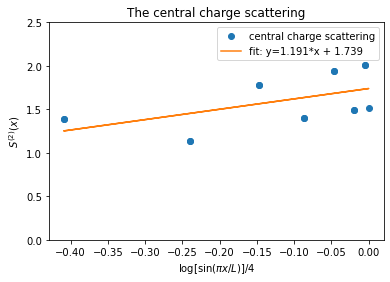

In [52]:
#plot central charge
x = np.arange(1,lx)
xaxis = np.log(np.sin(np.pi*x/lx))/4
yaxis = gpgpsi_dmrg.entanglement_entropy(2)
plt.plot(xaxis, yaxis, 'o', label='central charge scattering')

#fit the central charge
from scipy.optimize import curve_fit
def func(x, k, b):
    return k*x + b
popt, pcov = curve_fit(func, xaxis, yaxis)
plt.plot(xaxis, func(xaxis, *popt), label='fit: y=%5.3f*x + %5.3f' % tuple(popt))
plt.title('The central charge scattering')
plt.xlabel('$\log[\sin(\pi x/L)]/4$')
plt.ylabel('$S^{(2)}(x)$')
plt.ylim(0,2.5)
plt.legend()
plt.show()

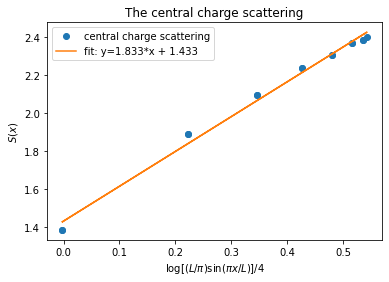

In [50]:
#plot central charge
x = np.arange(1,lx)
xaxis = np.log((lx/np.pi)*np.sin(np.pi*x/lx))/3
yaxis = gpgpsi_dmrg.entanglement_entropy()
plt.plot(xaxis, yaxis, 'o', label='central charge scattering')

#fit the central charge
from scipy.optimize import curve_fit
def func(x, k, b):
    return k*x + b
popt, pcov = curve_fit(func, xaxis, yaxis)
plt.plot(xaxis, func(xaxis, *popt), label='fit: y=%5.3f*x + %5.3f' % tuple(popt))
plt.title('The central charge scattering')
plt.xlabel('$\log[(L/\pi)\sin(\pi x/L)]/4$')
plt.ylabel('$S(x)$')
plt.legend()
plt.show()